# Structure example code
Run STRUCTURE on SNP data output by __ipyrad__. 


### A note on Jupyter/IPython
This is a Jupyter notebook, which is a mixture of __Python__ and __Bash__ scripts. The default is Python while cells with Bash code contain the header %%bash. If you run this code as an Jupyter notebook it will recognize the cell heading and run the appropriate code. If you are copy/pasting into a terminal, then you can similarly run both types of code by pasting the code into an IPython shell. Simply type ipython in a terminal to open the session. 

### Running this notebook
This notebook assumes you have the following software installed:
+ Structure (http://pritchardlab.stanford.edu/structure.html)
+ CLUMPP (https://web.stanford.edu/group/rosenberglab/clumpp.html)


### Import Python libraries

In [172]:
import numpy as np   ## numerical processing
import ipyparallel   ## parallel processing
import glob          ## file/string handling


### Make an output directory

In [2]:
%%bash
mkdir -p test_structure/

### Check that you have structure installed. 
You must be able to call structure from a terminal by typing __structure__. If not, follow the installation instructions in the structure docs to install the command-line version of the software. Below you can see that when I type structure a splash screen is printed and an error is listed that it can't find the params file. That is ok. We will create a params file below. 

In [3]:
%%bash
## test that structure is installed.
structure



----------------------------------------------------
STRUCTURE by Pritchard, Stephens and Donnelly (2000)
     and Falush, Stephens and Pritchard (2003)
       Code by Pritchard, Falush and Hubisz
             Version 2.3.4 (Jul 2012)
----------------------------------------------------


Can't open the file "mainparams".

Exiting the program due to error(s) listed above.



### Create/Download params files for STRUCTURE
This code downloads default _main_ and _extra_ files. We need to edit these files so that STRUCTURE recognizes the ipyrad .str file format. Namely, that there will be 6 blank columns before the data starts. I indicate below which parts of the file you should modify. 

In [68]:
%%bash
## download fresh (default) params files (or you could get them elsewhere)
## the argument string includes an upper-case o, not a zero. 
curl -LkO www.dereneaton.com/downloads/struct.main   
curl -LkO www.dereneaton.com/downloads/struct.extras 

## set the file format to match ipyrad structure format (6 blank columns)
## meaning no populations, locations, names, or phenotypes are indicated.
sed -i '/LABEL /c\#define LABEL 1 //'         struct.main
sed -i '/POPDATA /c\#define POPDATA 0 //'     struct.main
sed -i '/POPFLAG /c\#define POPFLAG 0 //'     struct.main
sed -i '/LOCDATA /c\#define LOCDATA 0 //'     struct.main
sed -i '/PHENOTYPE /c\#define PHENOTYPE 0 //' struct.main
sed -i '/EXTRACOLS /c\#define EXTRACOLS 0 //' struct.main

## you can change these values to modify run time
sed -i '/BURNIN /c\#define BURNIN 10000 //'     struct.main
sed -i '/NUMREPS /c\#define NUMREPS 50000 //'   struct.main

## we will set our own random seed
## we do not use POPDATA for location info
## we do not use prior POP info to aid assignments
sed -i '/RANDOMIZE /c\#define RANDOMIZE 0 //'   struct.extras
sed -i '/LOCISPOP /c\#define LOCISPOP 0 //'     struct.extras
sed -i '/USEPOPINFO /c\#define USEPOPINFO 0 //' struct.extras

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   4437      0 --:--:-- --:--:-- --:--:--  4684
100  2577  100  2577    0     0  30048      0 --:--:-- --:--:-- --:--:-- 30048
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   5259      0 --:--:-- --:--:-- --:--:--  5562
100  6260  100  6260    0     0  91483      0 --:--:-- --:--:-- --:--:-- 91483


### Creat a function to call structure
This function is just a Python wrapper to call structure and pass it a list of arguments. 

In [64]:
def structure(arglist):
    ## import subprocess inside func b/c running parallel
    import subprocess
    
    ## parse args
    kpop, rep, strfile, rseed, ninds, nloci, odir = arglist
    
    ## create call string
    outname = "{}/K{}_rep{}".format(odir, kpop, rep)
    args = [kpop, ninds, nloci, strfile, rseed, outname]
    cmd = """ structure \
              -m struct.main \
              -e struct.extras \
              -K {} \
              -N {} \
              -L {} \
              -i {} \
              -D {} \
              -o {} """.format(*args)

    ## call the shell function
    stdout = subprocess.check_call(cmd, shell=True)

### Organize input files
Enter your .str data file here, and the range of K values to test. 

In [55]:
mydatafile = "/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str"
kpops = [2,3]

Get number of taxa and SNPs in data set. 

In [71]:
with open(mydatafile, 'r') as ifile:
    lines = ifile.readlines()
    numinds = len(lines)//2
    nloci = len(lines[0].strip().split()[1:])
    print numinds, "samples in data set"
    print nloci, 'SNPs in structure data set'

6 samples in data set
1000 SNPs in structure data set


### Parallel processing 
Collect arguments to structure into a lists so we can pass them all to run in parallel on many processors. 

In [72]:
## out output directory that we created earlier
odir = "test_structure"

args = []
## for each value of K
for kpop in kpops:
    ## do ten replicates
    for rep in range(1, 11):
        ## get a random seed
        rand = np.random.randint(0, int(1e9), 1)[0]
        ## add arg list to args
        args.append([kpop, rep, mydatafile, rand, numinds, nloci, odir])

## print the args list
for i in args: 
    print i

[2, 1, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 777982912, 6, 1000, 'test_structure']
[2, 2, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 845106815, 6, 1000, 'test_structure']
[2, 3, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 196765534, 6, 1000, 'test_structure']
[2, 4, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 837954027, 6, 1000, 'test_structure']
[2, 5, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 11830001, 6, 1000, 'test_structure']
[2, 6, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 473753326, 6, 1000, 'test_structure']
[2, 7, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 401376115, 6, 1000, 'test_structure']
[2, 8, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 706730397, 6, 1000, 'test_structure']
[2, 9, '/home/deren/Documents/ipyrad/tests/test/dent_outfiles/dent.u.str', 885513546, 6, 1000, 't

In [73]:
## create a Parallel computing client
## parallel engines can be turned on in the notebook
## under the Clusters tab
ipyclient = ipyparallel.Client()
lbview = ipyclient.load_balanced_view()

In [74]:
## submit these jobs to the client to run in parallel
res = {}
for i in range(len(args)):
    res[i] = lbview.apply_async(structure, args[i])

In [75]:
## this will print progress until jobs are done
ipyclient.wait_interactive()

  20/20 tasks finished after  993 s
done


In [78]:
## to examine details of each individual job you could check the 'res' metadata
## this would include error information if a parallel job failed.
res[0].metadata

{'after': [],
 'completed': datetime.datetime(2016, 4, 18, 16, 0, 58, 205392),
 'data': {},
 'engine_id': 2,
 'engine_uuid': u'78729ee1-516c-41fa-80ab-5fb009d2a0e3',
 'error': None,
 'execute_input': None,
 'execute_result': None,
 'follow': [],
 'msg_id': u'fe43a075-4bd6-496a-ab8a-32f34fd18ada',
 'outputs': [],
 'received': datetime.datetime(2016, 4, 18, 16, 0, 58, 209474),
 'started': datetime.datetime(2016, 4, 18, 15, 57, 30, 803765),
 'status': u'ok',
 'stderr': '',
 'stdout': '',
 'submitted': datetime.datetime(2016, 4, 18, 15, 57, 30, 796288)}

### Summarize replicates with CLUMPP
Again, this part of the code assumes that you've downloaded and installed the software CLUMPP, which is used to summarize results across replicate runs of STRUCTURE. We ran ten replicates per K-value hypothesis. If you type CLUMPP into a terminal you should see the following message. Again, an error that there is no params file. Don't worry, we'll make one below. 

In [79]:
%%bash
CLUMPP


Error: Unable to open paramfile ''paramfile''
Please check the name of the paramfile.



### Create a CLUMPP params file

In [80]:
%%bash
## get template CLUMPP params file, I host a template file at this download
curl -LkO www.dereneaton.com/downloads/clumpp.paramfile 

## fill in the template: tell it the format to use individuals
sed -i '/type of data /c\DATATYPE 0                     # individuals //' clumpp.paramfile
#sed -i '/individuals or populations /c\C 39             # N individuals //' clumpp.paramfile
sed -i '/Print the permuted /c\PRINT_PERMUTED_DATA 0    # no print //' clumpp.paramfile

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   178  100   178    0     0   1108      0 --:--:-- --:--:-- --:--:--  4684
100  4928  100  4928    0     0  22953      0 --:--:-- --:--:-- --:--:-- 22953


### Create a function wrapper to call CLUMPP

In [102]:
def build_clumpp(kpop, odir): 
    """ A wrapper to call CLUMPP on structure results files for a given K-value"""
   
    ## grab all the _f result files
    repfiles = glob.glob("{}/K{}_rep*".format(odir, kpop))
    ## make an output handle
    outfile = open("{}/K{}.indfile".format(odir, kpop), 'w')
    
    ## combine replicates into the indfile
    for repfile in repfiles:
        i = 1
        ## strips junk to extract matrix
        for line in open(repfile).readlines():
            ## matrix lines have this junk
            if ")   :  " in line:
                ## split it up on whitespace
                ll = line.strip().split()
                outstr = " ".join([ll[0],ll[0],ll[2],ll[0].split('.')[0]])+" :  "+" ".join(ll[4:])
                outfile.write(outstr+"\n")
                i += 1
        outfile.write("\n")
    outfile.close()
    
    return len(repfiles), i-1

    
    
def run_clumpp(kpop, odir, ninds, nreps):
    ## create CLUMPP args string
    import subprocess
    cmd = """
           CLUMPP clumpp.paramfile \
           -i {odir}/K{kpop}.indfile \
           -o {odir}/K{kpop}.outfile \
           -j {odir}/K{kpop}.miscfile \
           -r {nreps} -c {ninds} -k {kpop} 
           """\
           .format(odir=odir, kpop=kpop, nreps=nreps, ninds=ninds)
    
    ## call CLUMPP
    subprocess.check_call(cmd, shell=True)

### Run CLUMPP for each K-value

In [103]:
for kpop in kpops:
    nreps, ninds = build_clumpp(kpop, odir)
    run_clumpp(kpop, odir, ninds, nreps)

### The order of samples in plots

In [106]:
indat = open(mydatafile, 'r').readlines()
names = [i.split()[0] for i in indat][::2]
for i,j in enumerate(names):
    print i+1, j

1 dentatum_ELS15
2 dentatum_ELS27
3 dentatum_ELS4
4 dentatum_ELS52
5 dentatum_ELS72
6 dentatum_ELS82


### Quick structure plot

In [167]:
def structplot(infile, kpop, ninds, colorder=[], barorder=[]):
    ## grab the data
    dat = open(infile).readlines()
    
    ## input to a sorted dict
    D = OrderedDict()
    for line in dat:
        ll = line.strip().split()
        vals = [float(i)*100 for i in ll[5:]]
    
        ## order of the bars
        if not barorder:
            D[ll[1]] = [vals[i] for i in range(kpop)]
        else: 
            D[ll[1]] = [vals[i] for i in barorder]
    
    ## sort into the same order of individuals
    ## as in the microsatellite data set of Cavender-Bares
    sorteds = range(1, ninds+1)
    
    ## ordered color map
    cmap = sns.color_palette("Set3", 8)
    #cmap = sns.dark_palette("skyblue", 8, reverse=True)
    if not colorder:
        ncmap = [cmap[i] for i in range(kpop)]
    else:
        ncmap = [cmap[i] for i in colorder]

    fig, ax = plt.subplots(figsize=(ninds/2.,2.0))

    ## normalize values to 100
    for i in D:
        D[i] = [100*(j/sum(D[i])) for j in D[i]]

    ## make plot
    for col in range(len(D.values()[0])):
        if col > 0:
            ax.bar(range(len(D.keys())), 
                   [D[str(i)][col] for i in sorteds],
                   bottom = [sum(D[str(i)][:col]) for i in sorteds],
                   color=ncmap[col], width=0.95, edgecolor='')       
        else:
            ax.bar(range(len(D.keys())), 
                   [D[str(i)][col] for i in sorteds],
                   bottom = 0, color=ncmap[col], width=0.95, edgecolor="")
            
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0., float(ninds))
    ax.set_ylim(-0., 100.)
    ax.grid(b=0)
    
    ## uncomment to save the figure 
    ## set format by changing the suffix (png, svg, etc.)
    #plt.savefig("figures/RADstruct_"+str(K)+".png", dpi=300)
    plt.show()


### K=2 plot

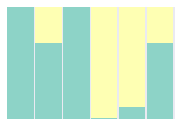

In [169]:
structplot("test_structure/K2.outfile", 2, ninds)

### K=3 plot

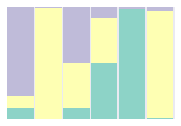

In [170]:
structplot("test_structure/K3.outfile", 3, ninds)

To change the order of colors use the colorder argument. Now green is stacked on top and yellow on the bottom.

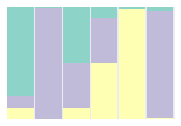

In [171]:
structplot("test_structure/K3.outfile", 3, ninds, colorder=[1,2,0])